# Calculation of control fields for Lindbladian dynamics using L-BFGS-B algorithm

Christian Arenz (christianarenz.ca@gmail.com), Alexander Pitchford (alex.pitchford@gmail.com)

Example to demonstrate using the control library to determine control
pulses using the ctrlpulseoptim.optimize_pulse function.
The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which in this case is given by the
'Trace difference' norm.

This in an open quantum system example, with a single qubit subject to
an amplitude damping channel. The target evolution is the Hadamard gate.
For a $d$ dimensional quantum system in general we represent the Lindbladian
as a $d^2 \times d^2$ dimensional matrix by vectorizing the denisty operator (row vectorization).
Here done for the Lindbladian that describes the amplitude damping channel
and the coherent drift- and control generators.
The user can experiment with the strength of the amplitude damping by
changing the gamma variable value

The user can experiment with the timeslicing, by means of changing the
number of timeslots and/or total time for the evolution.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

For more background on the pulse optimisation see:
[QuTiP overview - Optimal Control](http://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/example-optimal-control-overview.ipynb)  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip import hadamard_transform
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo

example_name = 'Lindblad'

### Defining the physics

In [3]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Si = identity(2)

Sd = Qobj(np.array([[0, 1],
             [0, 0]]))
Sm = Qobj(np.array([[0, 0],
             [1, 0]]))
Sd_m = Qobj(np.array([[1, 0],
              [0, 0]]))
Sm_d = Qobj(np.array([[0, 0],
              [0, 1]]))

#Amplitude damping#
#Damping rate:
gamma = 0.1
L0_Ad = gamma*(2*tensor(Sm, Sd.trans()) - 
            (tensor(Sd_m, Si) + tensor(Si, Sd_m.trans())))
#sigma X control
LC_x = -1j*(tensor(Sx, Si) - tensor(Si, Sx))
#sigma Y control
LC_y = -1j*(tensor(Sy, Si) - tensor(Si, Sy.trans()))
#sigma Z control
LC_z = -1j*(tensor(Sz, Si) - tensor(Si, Sz))

#Drift
drift = L0_Ad
#Controls
ctrls = [LC_z, LC_x]
# Number of ctrls
n_ctrls = len(ctrls)

initial = identity(4)
#Target
#Hadamard gate
had_gate = hadamard_transform(1)
target_DP = tensor(had_gate, had_gate)

### Defining the time evolution parameters

In [4]:
# Number of time slots
n_ts = 10
# Time allowed for the evolution
evo_time = 2

### Set the conditions which will cause the pulse optimisation to terminate

In [5]:
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 30
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

### Set the initial pulse type

In [6]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND'

### Give an extension for output files

In [7]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

### Run the optimisation

In [8]:
# Note that this call will take the defaults
#    dyn_type='GEN_MAT'
# This means that matrices that describe the dynamics are assumed to be
# general, i.e. the propagator can be calculated using:
# expm(combined_dynamics*dt)
#    prop_type='FRECHET'
# and the propagators and their gradients will be calculated using the
# Frechet method, i.e. an exact gradent
#    fid_type='TRACEDIFF'
# and that the fidelity error, i.e. distance from the target, is give
# by the trace of the difference between the target and evolved operators 
result = cpo.optimize_pulse(drift, ctrls, initial, target_DP, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                out_file_ext=f_ext, init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift dynamics generator:
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-0.2  0.   0.   0. ]
 [ 0.  -0.1  0.   0. ]
 [ 0.   0.  -0.1  0. ]
 [ 0.2  0.   0.   0. ]]
Control 1 dynamics generator:
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.-2.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+2.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
Control 2 dynamics generator:
Quantum object: dims = [

### Report the results

In [9]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:01.381297
Wall time computing Hamiltonians: 0:00:00.014886 (1.08%)
Wall time computing propagators: 0:00:01.221972 (88.47%)
Wall time computing forward propagation: 0:00:00.005346 (0.39%)
Wall time computing onward propagation: 0:00:00.004181 (0.30%)
Wall time computing gradient: 0:00:00.098572 (7.14%)

**** Iterations and function calls ****
Number of iterations: 201
Number of fidelity function calls: 257
Number of times fidelity is computed: 257
Number of gradient function calls: 257
Number of times gradients are computed: 257
Number of times timeslot evolution is recomputed: 257

**** Control amplitudes ****
Number of control amplitude updates: 256
Mean number of updates per iteration: 1.2736318407960199
Number of timeslot values changed: 2560
Mean number of timeslot changes per update: 10.0
Number of amplitude values changed: 5

### Plot the initial and final amplitudes

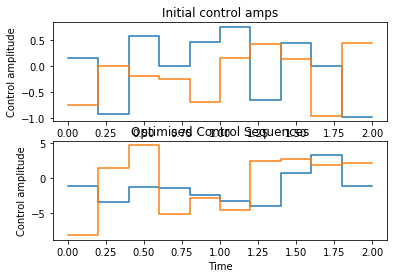

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(result.time, 
             np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])), 
             where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(result.time, 
             np.hstack((result.final_amps[:, j], result.final_amps[-1, j])), 
             where='post')

### Versions

In [11]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.1.0
Numpy,1.11.3
SciPy,0.18.1
matplotlib,2.0.0
Cython,0.25.2
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"3.6.0 |Anaconda 4.3.1 (64-bit)| (default, Dec 23 2016, 12:22:00) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
